# Part 1 - initial data analysis and visualisation

## Import libraries 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

from src import *

## Loading data

In [3]:
dataloader = CSVDataLoader('data/MSFT_2006-01-01_to_2018-01-01.csv')
raw_df = dataloader.load()

print(raw_df.info())
print()
print(raw_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB
None

         Date   Open   High    Low  Close     Volume  Name
0  2006-01-03  26.25  27.00  26.10  26.84   79974418  MSFT
1  2006-01-04  26.77  27.08  26.77  26.97   57975661  MSFT
2  2006-01-05  26.96  27.13  26.91  26.99   48247610  MSFT
3  2006-01-06  26.89  27.00  26.49  26.91  100969092  MSFT
4  2006-01-09  26.93  27.07  26.76  26.86   55627836  MSFT


## Visualise time-series

In [4]:
StockVisualizer(title="Detail view").visualize(raw_df[:50])

# Convert the Date column to datetime
raw_df["Date"] = pd.to_datetime(raw_df["Date"], format="%Y-%m-%d", errors="raise")

# Create a YearMonth column for grouping
raw_df["YearMonth"] = raw_df["Date"].dt.to_period("M")

# Aggregate monthly data
compressed_df = (
    raw_df.sort_values("Date")
    .groupby("YearMonth", group_keys=False)
    .apply(
        lambda g: pd.Series({
            "Date": g["Date"].iloc[-1],          # last trading day of the month
            "Open": g["Open"].iloc[0],           # open of first day
            "High": g["High"].max(),             # highest high
            "Low": g["Low"].min(),               # lowest low
            "Close": g["Close"].iloc[-1],        # close of last day
            "Volume": g["Volume"].sum(),         # total volume
            "Name": g["Name"].iloc[0]            # ticker
        }),
        include_groups=False
    )
    .reset_index(drop=True)
)


StockVisualizer(title="Global view").visualize(compressed_df)


## Time-series Decomposition

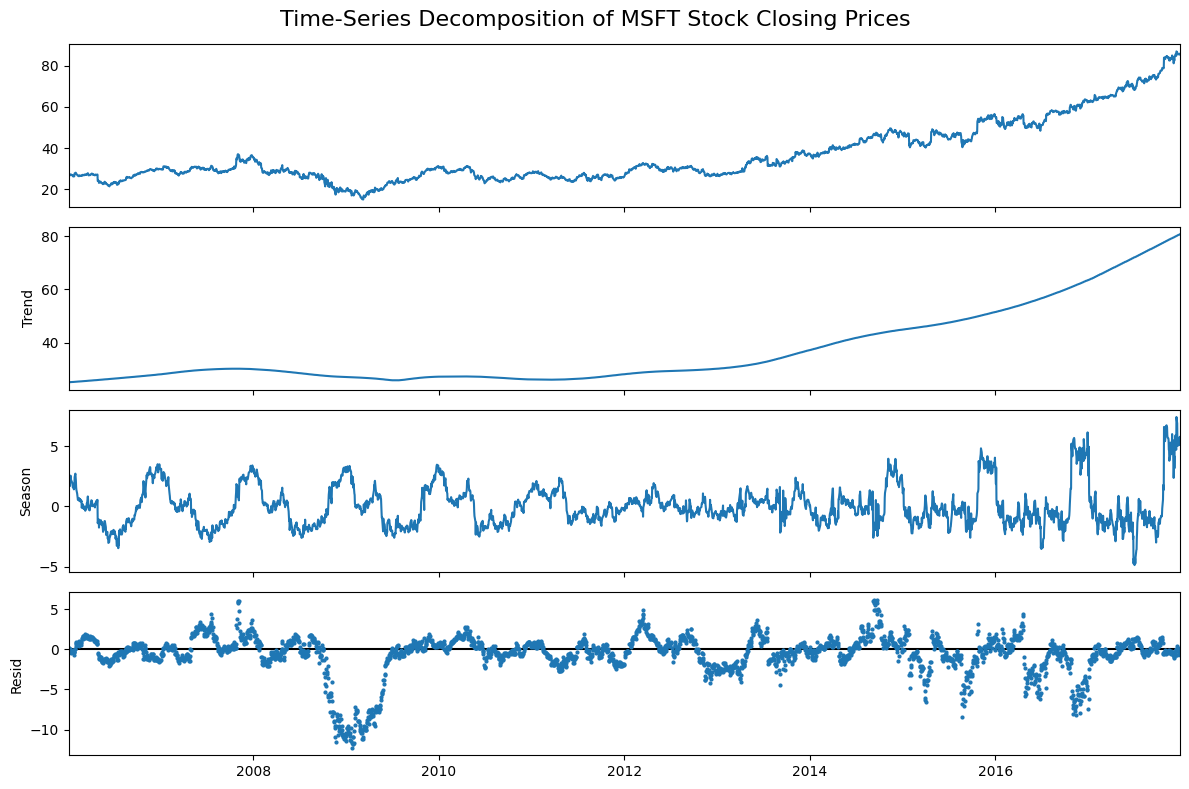

In [5]:
# Should help with black lines which are a rendering artifact in the notebook
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'

# Class for time-series decomposition of stock data using STL decomposition
# with 252 long period (trading days in a year)
decomposer = StockDecomposition()

# Set data from the raw dataframe
decomposer.set_data(df=raw_df)
decomposer.decompose()
decomposer.plot()

## Autocorelation analysis

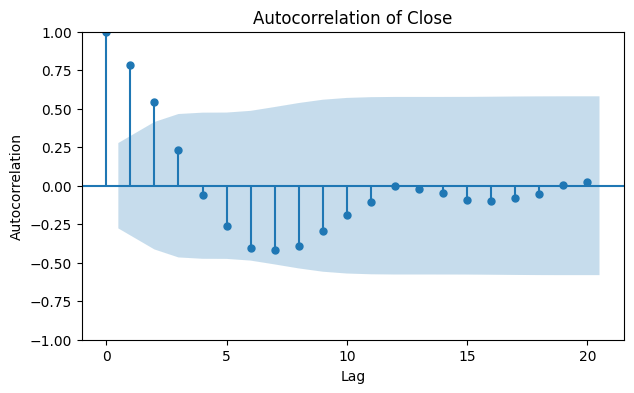

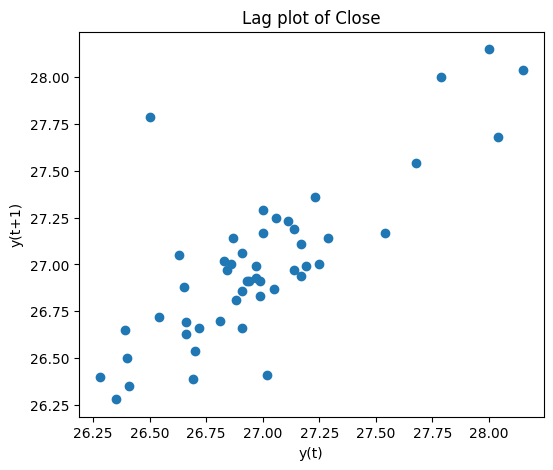

            t       t+1       t+2       t+3
t    1.000000  0.789317  0.551735  0.235982
t+1  0.789317  1.000000  0.789534  0.552524
t+2  0.551735  0.789534  1.000000  0.791130
t+3  0.235982  0.552524  0.791130  1.000000


In [8]:
autocorr = StockAutocorrelation(dpi=100)
# [0 - 50]
autocorr.prepare_data(df=raw_df, data_name="Close", idx_start=0, idx_end=50)

autocorr.plot_autocorelation(lags=20)
# The blue shaded area represents the boundary of 95% “statistical insignificance". Meaning, the bars inside this area are probably only random noise.

autocorr.plot_lag()
# [Close, (0-50)], The graph shows positive correlation between consecutive observations (day vs day+1). 
# The data points follow inreacing line. This means close price is consistent and isn't dominated by random noise in first 50 days.

autocorr.correlation_across_multiple_lags()

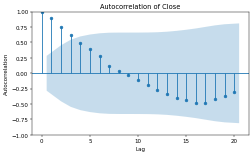

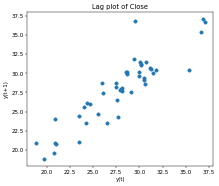

            t       t+1       t+2       t+3
t    1.000000  0.899563  0.755790  0.624765
t+1  0.899563  1.000000  0.898752  0.753624
t+2  0.755790  0.898752  1.000000  0.898899
t+3  0.624765  0.753624  0.898899  1.000000


In [7]:
raw_df["Date"] = pd.to_datetime(raw_df["Date"])

all_months = raw_df["Date"].dt.to_period("M").unique()
rows = []

for month in all_months:
    df_month = raw_df[raw_df['Date'].dt.to_period('M') == month]
    max_row = df_month.loc[df_month['Close'].idxmax()] # row with the biggest Close value
    rows.append(max_row)

monthly_max_close = pd.DataFrame(rows).reset_index(drop=True)

# ----- Monthly autocorelation, first 4 years (48 months) -----
autocorr.prepare_data(df=monthly_max_close, data_name="Close", idx_start=0, idx_end=48)
autocorr.plot_autocorelation(lags=20)
autocorr.plot_lag()
autocorr.correlation_across_multiple_lags()